# Pairs Trade Crypto (Static Hedge Ratio)

We're using the full history to determine the hedge ratio here.

In [59]:
import pandas as pd
import ccxt
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

plt.style.use("seaborn-v0_8")

### 1. Data Collection

Grabbing prices. We need to make sure enough datapoints for sufficient backtesting.

[[1697871600000, 0.65272632, 0.65459514, 0.651, 0.65330221, 0.0], [1697875200000, 0.65330218, 0.65474088, 0.65245696, 0.65256309, 0.0], [1697878800000, 0.65256305, 0.65600542, 0.65241608, 0.6557247, 0.0], [1697882400000, 0.65572951, 0.65699844, 0.654, 0.65598362, 0.0], [1697886000000, 0.65598362, 0.65887097, 0.655, 0.658, 0.0], [1697889600000, 0.658, 0.65884571, 0.65569656, 0.65569656, 0.0], [1697893200000, 0.65569507, 0.66311127, 0.65510072, 0.66283846, 0.0], [1697896800000, 0.66283842, 0.66498067, 0.66109262, 0.664, 0.0], [1697900400000, 0.664, 0.666, 0.6606895, 0.666, 0.0], [1697904000000, 0.666, 0.667, 0.66399587, 0.66423526, 0.0], [1697907600000, 0.66423523, 0.66976604, 0.66382957, 0.66896643, 0.0], [1697911200000, 0.66896643, 0.67071524, 0.664, 0.6690004, 0.0], [1697914800000, 0.6691561, 0.66969694, 0.663, 0.66581034, 0.0], [1697918400000, 0.66581034, 0.66586352, 0.66190201, 0.66488344, 0.0], [1697922000000, 0.66488344, 0.66800086, 0.66488344, 0.667, 0.0], [1697925600000, 0.667, 

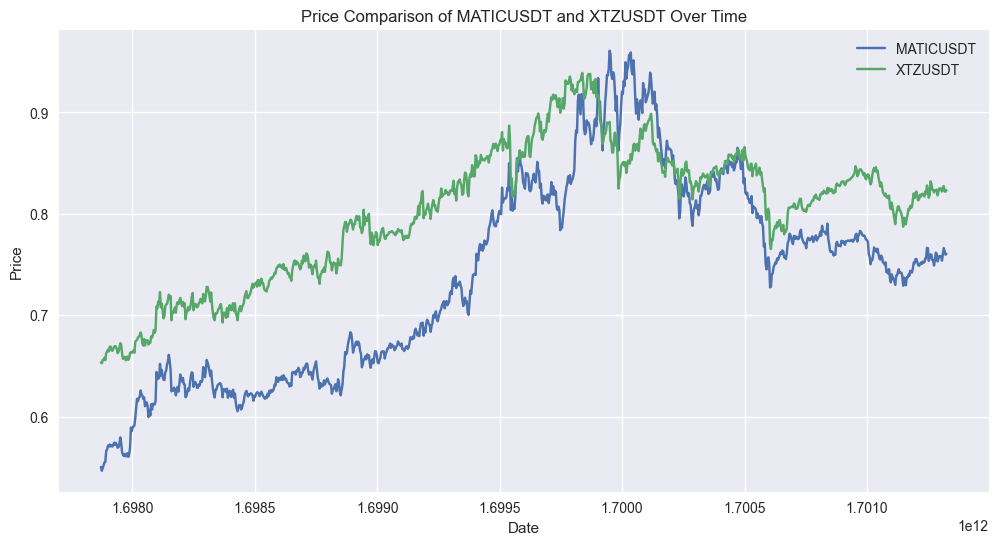

In [72]:
def fetch_prices(binance, symbol_one, symbol_two, look_back_days): 
    # Prepare empty dataframe for results
    df_final = pd.DataFrame()
    
    # Calculate the end timestamp for the data fetching
    end_timestamp = binance.milliseconds()
    since_timestamp = end_timestamp - look_back_days * 24 * 60 * 60 * 1000 
    
    while since_timestamp < end_timestamp:
        try:
            # Fetch OHLCV data
            ohlcv_theta = binance.fetch_ohlcv(symbol_two, '1h', since=since_timestamp, limit=1000, params={'price':'mark'})
            print(ohlcv_theta)
            ohlcv_xrp = binance.fetch_ohlcv(symbol_one, '1h', since=since_timestamp, limit=1000, params={'price':'mark'})
            
            # Create temporary dataframes to hold fetched data
            df_theta_temp = pd.DataFrame(ohlcv_theta, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df_xrp_temp = pd.DataFrame(ohlcv_xrp, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

            # Check if both dataframes have the same length
            if len(df_theta_temp) != len(df_xrp_temp):
                print(
                    f"Data length mismatch: {symbol_two} has {len(df_theta_temp)} rows, {symbol_one} has {len(df_xrp_temp)} rows.")
                return None
            
            # Merge dataframes
            df_temp = pd.merge(df_xrp_temp[['timestamp', 'close']], df_theta_temp[['timestamp', 'close']], on='timestamp', how='inner')
            df_temp.columns = ['timestamp', symbol_one, symbol_two]
            
            # Concatenate with the final dataframe
            df_final = pd.concat([df_final, df_temp])
            
            # Update the since_timestamp to the last timestamp fetched
            since_timestamp = df_final['timestamp'].max() + (60 * 60 * 1000)  # Add one hour

        except Exception as e:
            print(f"Error in fetching prices: {e}")
            break
    
    # Remove duplicates and sort the dataframe
    df_final.drop_duplicates(subset='timestamp', keep='first', inplace=True)
    df_final.sort_values(by='timestamp', inplace=True)
    
    return df_final


symbol_one = "MATICUSDT"
symbol_two = "XTZUSDT"

binance = ccxt.binance()

prices = fetch_prices(binance, symbol_one, symbol_two, 40)

# Convert 'timestamp' to datetime
prices['date'] = pd.to_datetime(prices['timestamp'], unit='ms')

# Set 'timestamp' as the index
prices.set_index('timestamp', inplace=True)

# Ensure there are no duplicates
prices.drop_duplicates(inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices[symbol_one], label=symbol_one)
plt.plot(prices.index, prices[symbol_two], label=symbol_two)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Price Comparison of {symbol_one} and {symbol_two} Over Time')
plt.legend()

# Display the plot
plt.show()

# Cointegration Check

In [73]:
x = prices[symbol_one]
y = prices[symbol_two]

if len(x) != len(y):
    print(f"Mismatch for Price Lengths")

result = coint(x, y)
score = result[0]
pvalue = result[1]

print("P Value: ", pvalue)

if pvalue < 0.05:
    print("Pair is Cointegrated")



P Value:  0.29931781191659523


In [74]:
lookback_window = 500
zscore_window = 30 # used for zscore calculation, must be less than lookback_window

upper_threshold = 2
lower_threshold = -2


Hedge Ratio:  0.615527934387005


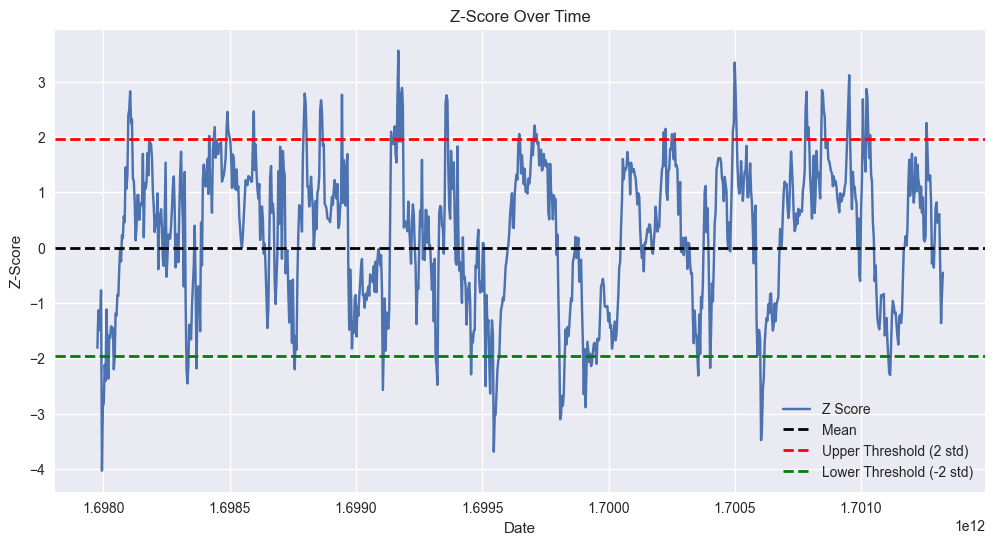

In [75]:

model = sm.OLS(y, sm.add_constant(x)).fit()
hedge_ratio = model.params[1]
prices['calculated_spread'] = prices[symbol_two] - hedge_ratio * prices[symbol_one]
print("Hedge Ratio: ", hedge_ratio)

# Calculate the rolling mean, standard deviation, and z-score
prices['rolling_mean_spread'] = prices['calculated_spread'].rolling(window=zscore_window).mean()
prices['rolling_std_spread'] = prices['calculated_spread'].rolling(window=zscore_window).std()
prices['z_score'] = (prices['calculated_spread'] - prices['rolling_mean_spread']) / prices['rolling_std_spread']

# Plot the z_score
plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices['z_score'], label='Z Score')
plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Mean')
plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='Upper Threshold (2 std)')
plt.axhline(-1.96, color='green', linestyle='--', linewidth=2, label='Lower Threshold (-2 std)')
plt.title('Z-Score Over Time')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Calculate Trading Signals

In [76]:
prices['trading_signal'] = 0
prices['symbol_one_position'] = 0
prices['symbol_two_position'] = 0
prices['portfolio_value'] = 10000

current_position = 0

selected_pair = prices.reset_index(drop=True)

# Set signals based on z-score thresholds
for i in range(1, len(selected_pair)):
    # If z-score crosses below lower threshold, go long on symbol_two (dependent)
    if selected_pair['z_score'].iloc[i] < lower_threshold and selected_pair['z_score'].iloc[i-1] >= lower_threshold:
        selected_pair['trading_signal'].iloc[i] = 1

    # If z-score crosses above upper threshold, go short on symbol_two (dependent)
    elif selected_pair['z_score'].iloc[i] > upper_threshold and selected_pair['z_score'].iloc[i-1] <= upper_threshold:
        selected_pair['trading_signal'].iloc[i] = -1

    # If z-score crosses the zero line from above or below, go neutral
    elif (selected_pair['z_score'].iloc[i] < 0.25 and selected_pair['z_score'].iloc[i-1] > 0.25) or \
            (selected_pair['z_score'].iloc[i] > -0.25 and selected_pair['z_score'].iloc[i-1] < -0.25):
        selected_pair['trading_signal'].iloc[i] = 0

    # If z-score crosses the zero line from above or below, close positions
    elif (selected_pair['z_score'].iloc[i] < 0 and selected_pair['z_score'].iloc[i-1] > 0) or \
            (selected_pair['z_score'].iloc[i] > 0 and selected_pair['z_score'].iloc[i-1] < 0):
        selected_pair['trading_signal'].iloc[i] = 0

    # Else, maintain the previous signal
    else:
        selected_pair['trading_signal'].iloc[i] = selected_pair['trading_signal'].iloc[i-1]


/var/folders/c4/11fd2lv91l5_7272pxxms3240000gn/T/ipykernel_64196/1141696589.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair['trading_signal'].iloc[i] = selected_pair['trading_signal'].iloc[i-1]
/var/folders/c4/11fd2lv91l5_7272pxxms3240000gn/T/ipykernel_64196/1141696589.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair['trading_signal'].iloc[i] = selected_pair['trading_signal'].iloc[i-1]
/var/folders/c4/11fd2lv91l5_7272pxxms3240000gn/T/ipykernel_64196/1141696589.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

## Run Backtest

In [77]:
entry_tracking = {
    symbol_one: {
        'units': 0,
        'price': 0,
    },
    symbol_two: {
        'units': 0,
        'price': 0
    },
    'portfolio_entry_value': 10000
}

for index, row in selected_pair.iterrows():

    # Skip the first row
    if index == 0:
        continue
    
    trading_signal = row['trading_signal']
    z_score = row['z_score']
    symbol_one_price = row[symbol_one] 
    symbol_two_price = row[symbol_two]  
    portfolio_value = selected_pair.at[index - 1, 'portfolio_value']
    
    # When we stay neutral
    if current_position == 0 and trading_signal == 0:
        
        # Maintaining Parameters from previous row
        selected_pair.at[index, 'symbol_one_position'] =  selected_pair.at[index - 1, 'symbol_one_position'] 
        selected_pair.at[index, 'symbol_two_position'] =  selected_pair.at[index - 1, 'symbol_two_position'] 
        selected_pair.at[index, 'portfolio_value'] =  selected_pair.at[index - 1, 'portfolio_value']  
        
    # Buy Symbol One, Short Symbol Two Condition (LONG SPREAD)
    if current_position == 0 and trading_signal == 1:

        # Allocate according to half of portfolio_value
        allocate = portfolio_value / 2
        symbol_two_long_qty = allocate / symbol_two_price
        symbol_one_short_qty = symbol_two_long_qty * hedge_ratio

        selected_pair.at[index, 'symbol_two_position'] = symbol_two_long_qty
        selected_pair.at[index, 'symbol_one_position'] = -symbol_one_short_qty

        # portfolio value shouldnt change
        selected_pair.at[index, 'portfolio_value'] = selected_pair.at[index - 1, 'portfolio_value']

        # Update entry tracking
        entry_tracking[symbol_one]['units'] = symbol_one_short_qty
        entry_tracking[symbol_one]['price'] = symbol_one_price

        entry_tracking[symbol_two]['units'] = symbol_two_long_qty
        entry_tracking[symbol_two]['price'] = symbol_two_price

        # Update portfolio entry value, we entered a position, record our entry portfolio value
        entry_tracking['portfolio_entry_value'] = selected_pair.at[index - 1, 'portfolio_value']

        # update current position 
        current_position = 1

     # Short Symbol One, Buy Symbol Two Condition (SHORT SPREAD)
    elif current_position == 0 and trading_signal == -1:

        # Allocate according to half of portfolio_value
        allocate = portfolio_value / 2
        symbol_two_short_qty = allocate / symbol_two_price
        symbol_one_long_qty = symbol_two_short_qty * hedge_ratio

        selected_pair.at[index, 'symbol_one_position'] = symbol_one_long_qty
        selected_pair.at[index, 'symbol_two_position'] = -symbol_two_short_qty

        # portfolio value shouldnt change
        selected_pair.at[index, 'portfolio_value'] = selected_pair.at[index - 1, 'portfolio_value']

        # Update entry tracking
        entry_tracking[symbol_one]['units'] = symbol_one_long_qty
        entry_tracking[symbol_one]['price'] = symbol_one_price

        entry_tracking[symbol_two]['units'] = symbol_two_short_qty
        entry_tracking[symbol_two]['price'] = symbol_two_price

        # Update portfolio entry value, we entered a position, record our entry portfolio value
        entry_tracking['portfolio_entry_value'] = selected_pair.at[index - 1, 'portfolio_value']

        # update current position 
        current_position = -1

    # If we are maintaining a long or short spread position, logic should be the same
    elif (current_position == 1 and trading_signal == 1) or (current_position == -1 and trading_signal == -1):

        # Maintaining Parameters from previous row
        selected_pair.at[index, 'symbol_one_position'] =  selected_pair.at[index - 1, 'symbol_one_position'] 
        selected_pair.at[index, 'symbol_two_position'] =  selected_pair.at[index - 1, 'symbol_two_position'] 

        # Updating portfolio value with current prices
        portfolio_entry_value = entry_tracking['portfolio_entry_value'] 

        # Long Symbol Two and Short hedge ratio * symbol one
        if trading_signal == 1:

            # Long case. Gains would be current - entry
            symbol_two_entry_value = entry_tracking[symbol_two]['units'] * entry_tracking[symbol_two]['price']
            symbol_two_current_value = entry_tracking[symbol_two]['units'] * symbol_two_price
            symbol_two_gain = symbol_two_current_value - symbol_two_entry_value 


            # Short case Gains would be entry - current
            symbol_one_entry_value = entry_tracking[symbol_one]['units'] * entry_tracking[symbol_one]['price']
            symbol_one_current_value = entry_tracking[symbol_one]['units'] * symbol_one_price
            symbol_one_gain = symbol_one_entry_value - symbol_one_current_value 

            total_gain = symbol_one_gain + symbol_two_gain
            selected_pair.at[index, 'portfolio_value'] = portfolio_entry_value + total_gain

        # Shorting Symbol Two and Longing hedge ratio * symbol One
        if trading_signal == -1:
            
            # Short case Gains would be entry - current
            symbol_two_entry_value = entry_tracking[symbol_two]['units'] * entry_tracking[symbol_two]['price']
            symbol_two_current_value = entry_tracking[symbol_two]['units'] * symbol_two_price
            symbol_two_gain = symbol_two_entry_value - symbol_two_current_value 

            # Long Case Gains would be current - Entry
            symbol_one_entry_value = entry_tracking[symbol_one]['units'] * entry_tracking[symbol_one]['price']
            symbol_one_current_value = entry_tracking[symbol_one]['units'] * symbol_one_price
            symbol_one_gain = symbol_one_current_value - symbol_one_entry_value 

            total_gain = symbol_one_gain + symbol_two_gain
            selected_pair.at[index, 'portfolio_value'] = portfolio_entry_value + total_gain

    # Go Neutral
    elif current_position != 0 and trading_signal == 0:
        
        # Update Portfolio Value once we've exited positions
        if current_position == 1:

             # Long case. Gains would be current - entry
            symbol_two_entry_value = entry_tracking[symbol_two]['units'] * entry_tracking[symbol_two]['price']
            symbol_two_current_value = entry_tracking[symbol_two]['units'] * symbol_two_price
            symbol_two_gain = symbol_two_current_value - symbol_two_entry_value 

            # Short case Gains would be entry - current
            symbol_one_entry_value = entry_tracking[symbol_one]['units'] * entry_tracking[symbol_one]['price']
            symbol_one_current_value = entry_tracking[symbol_one]['units'] * symbol_one_price
            symbol_one_gain = symbol_one_entry_value - symbol_one_current_value 

            total_gain = symbol_one_gain + symbol_two_gain
            selected_pair.at[index, 'portfolio_value'] = portfolio_entry_value + total_gain


        if current_position == -1:
            
            # Short case Gains would be entry - current
            symbol_two_entry_value = entry_tracking[symbol_two]['units'] * entry_tracking[symbol_two]['price']
            symbol_two_current_value = entry_tracking[symbol_two]['units'] * symbol_two_price
            symbol_two_gain = symbol_two_entry_value - symbol_two_current_value 

            # Long Case Gains would be current - Entry
            symbol_one_entry_value = entry_tracking[symbol_one]['units'] * entry_tracking[symbol_one]['price']
            symbol_one_current_value = entry_tracking[symbol_one]['units'] * symbol_one_price
            symbol_one_gain = symbol_one_current_value - symbol_one_entry_value 

            total_gain = symbol_one_gain + symbol_two_gain
            selected_pair.at[index, 'portfolio_value'] = portfolio_entry_value + total_gain


        # Update positions, since at this point we have exited
        selected_pair.at[index, 'symbol_one_position'] = 0
        selected_pair.at[index, 'symbol_two_position'] = 0

        # update current position 
        current_position = 0
        

selected_pair['returns'] = np.log(selected_pair['portfolio_value'] / selected_pair['portfolio_value'].shift(1))
selected_pair.to_csv("backtest_static_hedge.csv", index=True)


# Calculate mean and standard deviation of hourly returns
mean_return_hourly = selected_pair['returns'].mean()
std_deviation_hourly = selected_pair['returns'].std()

# Annualize the returns and standard deviation
annual_factor = 24 * 365
annualized_mean_return = mean_return_hourly * annual_factor
annualized_std_deviation = std_deviation_hourly * (annual_factor ** 0.5)

# Assuming a risk-free rate (modify this according to the appropriate rate for your analysis)
risk_free_rate = 0.03  # Example: 2% annual rate

# Calculate the Sharpe Ratio
sharpe_ratio = (annualized_mean_return - risk_free_rate) / annualized_std_deviation

print("SHARPE RATIO: ", sharpe_ratio)



SHARPE RATIO:  0.2589337792711387
